In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import os
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Save path

In [2]:
checkpoint_dir = '/content/drive/MyDrive/Your_Directory/SIAMB.pth'
os.makedirs(checkpoint_dir, exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
ENC_WEIGHT_PATH = os.path.join(checkpoint_dir, f'enc_weight_SIAMBB2.pth')
OPTIM_WEIGHT_PATH = os.path.join(checkpoint_dir, f'optim_weight_SIAMBB2.pth')

best weight save

In [3]:
BEST_ENC_WEIGHT_PATH = '/content/drive/MyDrive/Untitled Folder/best_enc.pth'
BEST_OPTIM_WEIGHT_PATH = '/content/drive/MyDrive/Untitled Folder/best_optim.pth'

Load path

In [17]:
ENC_WEIGHT_LOAD = '/content/drive/MyDrive/Your_Directory/SIAMB.pth/enc_weight_SIAMBB.pth'
OPTIM_WEIGHT_LOAD = '/content/drive/MyDrive/Your_Directory/SIAMB.pth/optim_weight_SIAMBB.pth'

DEVICE

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [7]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def random_sharpness(self, img):
        sharpness_factor = np.random.uniform(0.5, 2.0)
        img = transforms.functional.adjust_sharpness(img, sharpness_factor)
        return img

    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0]).convert('RGB')
        img1 = Image.open(img1_tuple[0]).convert('RGB')

        img0 = transforms.functional.resize(img0, (256, 256))
        img1 = transforms.functional.resize(img1, (256, 256))

        img0 = self.random_sharpness(img0)
        img1 = self.random_sharpness(img1)

        if random.random() < 0.5:
            img0 = transforms.functional.to_grayscale(img0, num_output_channels=3)
        if random.random() < 0.5:
            img1 = transforms.functional.to_grayscale(img1, num_output_channels=3)

        img0 = img0.convert('RGB')
        img1 = img1.convert('RGB')

        angle = random.uniform(-30, 30)
        img0 = transforms.functional.rotate(img0, angle)
        img1 = transforms.functional.rotate(img1, angle)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Train Dataset

In [8]:
folder_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/dataset/train")

In [9]:
transformation = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor()
                                    ])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

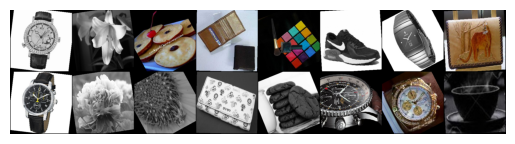

[0. 0. 1. 0. 1. 1. 0. 1.]


In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Model

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 512, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512 * 8 * 2, 3000),
            nn.ReLU(inplace=True),

            nn.Linear(3000, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 250)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

*Loss* function

In [12]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [13]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

Load model

In [18]:
encoder = SiameseNetwork().to(DEVICE)
try:
    encoder.load_state_dict(torch.load(ENC_WEIGHT_LOAD))
    print('Loaded encoder weight')
except:
    print('Encoder weight not found')


criterion = ContrastiveLoss()

optimizer = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.9)
try:
    optimizer.load_state_dict(torch.load(OPTIM_WEIGHT_LOAD))
    print('Loaded optimizer weight')
except:
    print('Optimizer weight not found')

Loaded encoder weight
Loaded optimizer weight


Val Dataset

In [15]:
val_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/dataset/val")

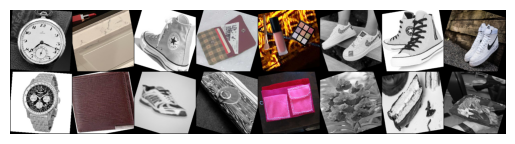

[0. 1. 0. 0. 1. 1. 1. 1.]


In [16]:
siamese_valset = SiameseNetworkDataset(imageFolderDataset=val_dataset,
                                        transform=transformation)

val_dataloader = DataLoader(siamese_valset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Test and Val

In [ ]:
training_losses = []
validation_losses = []

loss_contrastive = 1.0

best_model_state_dict = encoder.state_dict()
best_val_loss = float('inf')

epoch = 0
while loss_contrastive > 0.01:

    train_dataloader_tqdm = tqdm(train_dataloader, total=len(train_dataloader), leave=True)

    for i, (img0, img1, label) in enumerate(train_dataloader_tqdm, 0):

        img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()

        output1, output2 = encoder(img0, img1)

        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward()

        optimizer.step()

    training_loss = loss_contrastive.item()
    training_losses.append(training_loss)

    print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")

    torch.save(encoder.state_dict(), ENC_WEIGHT_PATH)
    torch.save(optimizer.state_dict(), OPTIM_WEIGHT_PATH)
    print("Checkpoint saved")

    encoder.eval()
    val_loss = 0.0

    with torch.no_grad():
        for i, (val_img0, val_img1, val_label) in enumerate(val_dataloader, 0):

            val_img0, val_img1, val_label = val_img0.to(DEVICE), val_img1.to(DEVICE), val_label.to(DEVICE)

            val_output1, val_output2 = encoder(val_img0, val_img1)

            val_loss += criterion(val_output1, val_output2, val_label).item()

    val_loss /= len(val_dataloader)
    validation_losses.append(val_loss)

    print(f"Validation loss: {val_loss}\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = encoder.state_dict()
        torch.save(encoder.state_dict(), BEST_ENC_WEIGHT_PATH)
        torch.save(optimizer.state_dict(), BEST_OPTIM_WEIGHT_PATH)

    encoder.train()

    epoch += 1

    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/Your_Directory/SIAMBB2.png')
    plt.show()

Test dataset

In [19]:
class SiameseNetworkDatatest(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0]).convert('RGB')
        img1 = Image.open(img1_tuple[0]).convert('RGB')

        img0 = transforms.functional.resize(img0, (256, 256))
        img1 = transforms.functional.resize(img1, (256, 256))

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

For checking

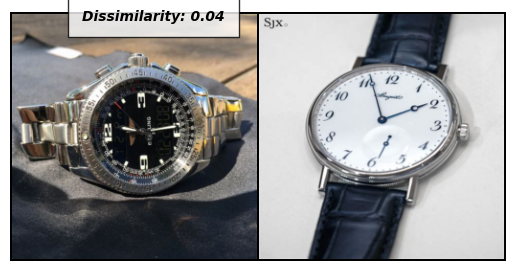

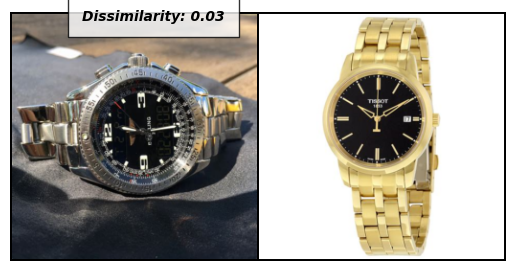

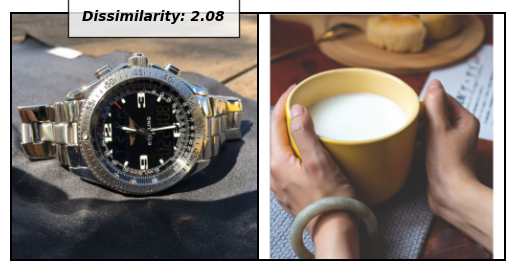

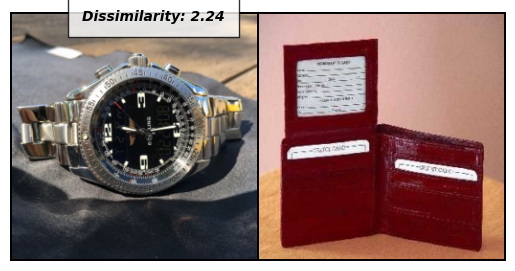

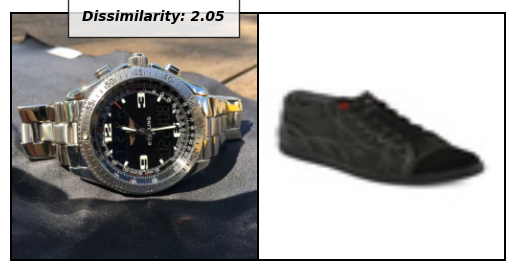

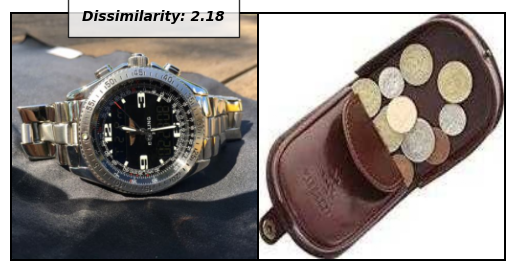

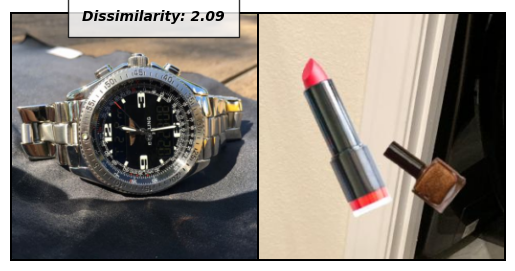

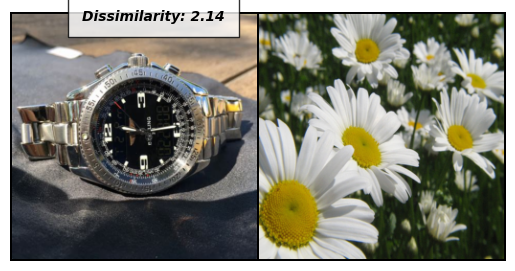

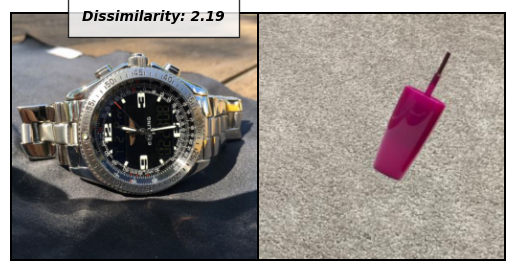

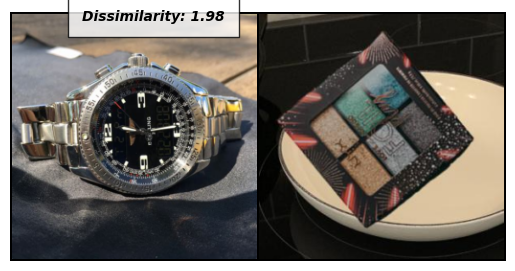

In [37]:
folder_dataset_test = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/test')
siamese_dataset = SiameseNetworkDatatest(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=1, batch_size=1, shuffle=True)


dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = encoder(x0.to(DEVICE), x1.to(DEVICE))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')